Loads data from the dataset and applies transformntions


In [1]:

import matplotlib.pyplot as plt # for plotting
import numpy as np # for transformation

import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer

from torch.optim.lr_scheduler import ReduceLROnPlateau


batch_size = 32

mean = [0.4330, 0.3819, 0.2964]
std = [0.2545, 0.2044, 0.2163]

def load_data():

    data_transforms = {
    'training1' : transforms.Compose([transforms.Resize((112,112)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)]),

    'training2' : transforms.Compose([transforms.Resize((112,112)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)]),

    'training3' : transforms.Compose([transforms.Resize((112,112)),
                                    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                                    transforms.RandomPerspective(distortion_scale=0.4, p=0.6),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)]),

    'validation' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'testing' : transforms.Compose([transforms.Resize((112,112)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)])
    }

    train_set1 = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=data_transforms['training1'])
    train_set2 = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=data_transforms['training2'])
    train_set3 = torchvision.datasets.Flowers102(root='./data', split="train", download=True, transform=data_transforms['training3'])

    print(len(train_set1))

    big_train_set = torch.utils.data.ConcatDataset([train_set1,train_set2])
    final_train_set = torch.utils.data.ConcatDataset([big_train_set,train_set3])

    print(len(final_train_set))

    train_loader = torch.utils.data.DataLoader(final_train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    print(len(train_loader))

    test_set = torchvision.datasets.Flowers102(root='./data', split="test", download=True, transform=data_transforms['testing'])
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    val_set = torchvision.datasets.Flowers102(root='./data', split="val", download=True, transform=data_transforms['testing'])
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)                                        
    
    return final_train_set, test_set, val_set, test_loader, train_loader, val_loader

train_set, test_set, val_set, test_loader, train_loader, val_loader = load_data()

1020
3060
96


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


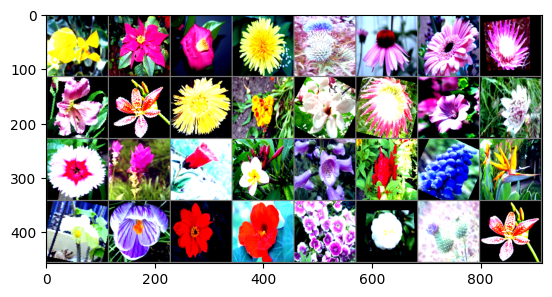

tensor(94)
tensor(43)
tensor(95)
tensor(49)
tensor(13)
tensor(16)
tensor(40)
tensor(12)
tensor(17)
tensor(101)
tensor(11)
tensor(45)
tensor(86)
tensor(12)
tensor(85)
tensor(37)
tensor(29)
tensor(38)
tensor(2)
tensor(80)
tensor(93)
tensor(26)
tensor(24)
tensor(7)
tensor(96)
tensor(66)
tensor(55)
tensor(88)
tensor(29)
tensor(95)
tensor(13)
tensor(101)


In [2]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(train_loader)
images, labels = next(dataiter)

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
for i in range(batch_size):
  print(labels[i])

In [3]:
class Net(nn.Module):
	
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5) 
        self.bn2 = nn.BatchNorm2d(32)

        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(32 * 53 * 53, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 102)

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=89888, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=102, bias=True)
)


In [4]:
class Net(nn.Module):
	
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5) 
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 5) 
        self.bn3 = nn.BatchNorm2d(64)

        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(36864, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 102)

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=36864, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=102, bias=True)
)


In [19]:
class Net(nn.Module):
	
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5) 
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 5) 
        self.bn3 = nn.BatchNorm2d(64)

        self.fl = nn.Flatten()

        self.fc1 = nn.Linear(36864, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 102)
        self.dropout = nn.Dropout(0.5) 

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fl): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=12800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=102, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
class Net(nn.Module):
	
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, 5) 
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 5) 
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 5) 
        self.bn4 = nn.BatchNorm2d(128)

        self.fl = nn.Flatten()

        self.fc1 = nn.Linear(12800, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 102)
        self.dropout = nn.Dropout(0.5) 

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [2]:
class Net(nn.Module):
	
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 48, 5) 
        self.bn2 = nn.BatchNorm2d(48)

        self.conv3 = nn.Conv2d(48, 104, 5) 
        self.bn3 = nn.BatchNorm2d(104)

        self.conv4 = nn.Conv2d(104, 256, 5) 
        self.bn4 = nn.BatchNorm2d(256)

        self.fl = nn.Flatten()

        self.fc1 = nn.Linear(25600, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 102)
        self.dropout = nn.Dropout(0.5) 

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.fl(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [12]:
class Net(nn.Module):
	
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, 5)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 128, 5) 
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 256, 5) 
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, 5) 
        self.bn4 = nn.BatchNorm2d(512)

        self.fl = nn.Flatten()

        self.fc1 = nn.Linear(4608, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 102)
        self.dropout = nn.Dropout(0.75) 

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.fl(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [17]:
class Net(nn.Module):
	
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 128, 5)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 5) 
        self.bn2 = nn.BatchNorm2d(256)

        self.conv3 = nn.Conv2d(256, 512, 5) 
        self.bn3 = nn.BatchNorm2d(512)

        self.conv4 = nn.Conv2d(512, 1024, 5) 
        self.bn4 = nn.BatchNorm2d(1024)

        self.fl = nn.Flatten()

        self.fc1 = nn.Linear(1024*3*3, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 102)
        self.dropout = nn.Dropout(0.75) 

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.fl(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [3]:
def optimLossSched(net, lr, wd):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

    return optimizer, criterion, scheduler

In [4]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [5]:
def test(data, model):
    correct = 0
    total = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    with torch.no_grad():
        for value in data:
            images, labels = value
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #print('Accuracy of the network on the 10000 test images: %d %%' % (
    #    100 * correct / total))
    
    return (100 * correct / total)

In [6]:
from torch.autograd import Variable

def train(epoch_num, model):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    trainingEpoch_loss = []
    validationEpoch_loss = []
    LRatEpoch = []

    for epoch in range(epoch_num):  # loop over the dataset multiple times
        running_loss = 0.0
        model.train()
        for i, (images, labels) in enumerate(train_loader, 0):
            
            # get the inputs; data is a list of [inputs, labels]
            images = images.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
            

        valid_loss = 0.0
        model.eval()
        for i, (images, labels) in enumerate(val_loader, 0):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            vloss = criterion(outputs, labels)
            valid_loss = vloss.item()*images.size(0)

        acc = round(test(val_loader, model),3)

        print(f'Epoch {epoch+1}  -   Lr: {get_lr(optimizer)}  -   Training Loss: {round(running_loss / len(train_loader),3)}  -   Validation Loss: {round(valid_loss / len(val_loader),3)}  -   Val Accuracy: {acc}%')

        trainingEpoch_loss.append(running_loss / len(train_loader))
        validationEpoch_loss.append(valid_loss / len(val_loader))
        LRatEpoch.append(get_lr(optimizer))

        scheduler.step(running_loss)


    return trainingEpoch_loss, validationEpoch_loss, LRatEpoch



Hyper param tuning:

In [10]:
from sklearn.model_selection import ParameterGrid

hyperparams = {
    'lr': [0.001],
    'l1': [400],
    'l2': [350],
    'wd': [0.1, 0.01, 0.001]
}

param_grid = list(ParameterGrid(hyperparams))

8


In [14]:
if __name__ == "__main__":
    results = []
    num = 0
    for params in param_grid:
        net = Net(l1=params['l1'], l2=params['l2'])

        optimizer, criterion, scheduler = optimLossSched(net, params['lr'], params['wd'])

        trainingLoss, valLoss, lrEpoch = train(50, net)
        print('Finished Training')
        acc = test(test_loader, net)

        results.append([acc, params['l1'], params['l2'],params['lr'],params['wd']])
        num +=1
        print(num,"/",len(param_grid))

    

The model will be running on cuda:0 device
494201.5
Finished Training
Accuracy of the network on the 10000 test images: 12 %
1 / 3
The model will be running on cuda:0 device
485159.8125
Finished Training
Accuracy of the network on the 10000 test images: 33 %
2 / 3
The model will be running on cuda:0 device
503331.78125
Finished Training
Accuracy of the network on the 10000 test images: 34 %
3 / 3


In [15]:
for i in results:
    print(i)

[12.538624166531143, 400, 350, 0.001, 0.1]
[33.53390795251261, 400, 350, 0.001, 0.01]
[34.54220198406245, 400, 350, 0.001, 0.001]


In [19]:
if __name__ == "__main__":
    torch.cuda.empty_cache()
    net = Net(l1=400, l2=350)

    optimizer, criterion, scheduler = optimLossSched(net, 0.001, 0.01)

    # train the model with epoch number, model
    trainingLoss, valLoss, lrEpoch = train(120, net)
    print('Finished Training') 

The model will be running on cuda:0 device
Epoch 1  -   Lr: 0.001  -   Training Loss: 4.544  -   Validation Loss: 3.878  -   Val Accuracy: 6.863%
Epoch 2  -   Lr: 0.001  -   Training Loss: 4.306  -   Validation Loss: 3.515  -   Val Accuracy: 12.745%
Epoch 3  -   Lr: 0.001  -   Training Loss: 4.076  -   Validation Loss: 3.185  -   Val Accuracy: 16.569%
Epoch 4  -   Lr: 0.001  -   Training Loss: 3.844  -   Validation Loss: 3.035  -   Val Accuracy: 18.725%
Epoch 5  -   Lr: 0.001  -   Training Loss: 3.621  -   Validation Loss: 2.863  -   Val Accuracy: 22.941%
Epoch 6  -   Lr: 0.001  -   Training Loss: 3.382  -   Validation Loss: 2.624  -   Val Accuracy: 26.373%
Epoch 7  -   Lr: 0.001  -   Training Loss: 3.228  -   Validation Loss: 2.514  -   Val Accuracy: 27.647%
Epoch 8  -   Lr: 0.001  -   Training Loss: 3.027  -   Validation Loss: 2.045  -   Val Accuracy: 33.725%
Epoch 9  -   Lr: 0.001  -   Training Loss: 2.83  -   Validation Loss: 1.685  -   Val Accuracy: 32.843%
Epoch 10  -   Lr: 0.001

In [20]:
def plotLoss(trainingLoss, valLoss, lr):
    from matplotlib import pyplot as plt

    lrNew = [(i * 1000) * 2 for i in lr]

    plt.plot(trainingLoss, label='train_loss')
    plt.plot(valLoss, label='val_loss')
    plt.plot(lrNew, label='lr')

    plt.legend()
    plt.show

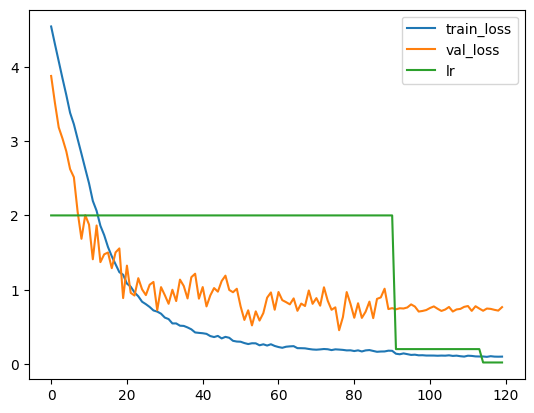

In [21]:
# plot the training loss and validation loss over all epochs
plotLoss(trainingLoss, valLoss, lrEpoch)

In [22]:
# print accuracy on all sets

# Accuracy on training data
print("Training on final: ",round(test(train_loader, net),4),"%")
print("--------------")

# Accuracy on valid data
print("Valid on final: ",round(test(val_loader, net),4),"%")
print("--------------") 

# Accuracy on test data
print("Test on final: ",round(test(test_loader, net),4),"%")




Training on final:  99.9346 %
--------------
Valid on final:  67.0588 %
--------------
Test on final:  62.1402 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


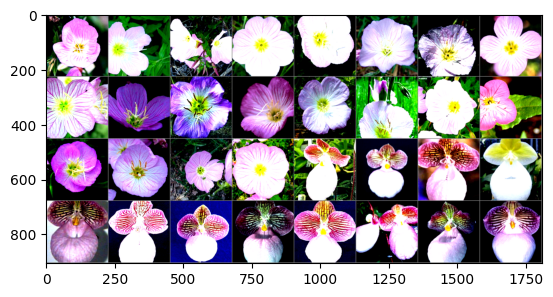

GroundTruth: 
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


In [19]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ')
for i in range(32):
  print(labels[i])

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)
outputs = net(images)

_, predicted = torch.max(outputs, 1)

for i in range(32):
  print(predicted[i])


tensor(33, device='cuda:0')
tensor(0, device='cuda:0')
tensor(21, device='cuda:0')
tensor(0, device='cuda:0')
tensor(68, device='cuda:0')
tensor(0, device='cuda:0')
tensor(33, device='cuda:0')
tensor(0, device='cuda:0')
tensor(67, device='cuda:0')
tensor(95, device='cuda:0')
tensor(8, device='cuda:0')
tensor(44, device='cuda:0')
tensor(0, device='cuda:0')
tensor(75, device='cuda:0')
tensor(0, device='cuda:0')
tensor(98, device='cuda:0')
tensor(51, device='cuda:0')
tensor(0, device='cuda:0')
tensor(77, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(67, device='cuda:0')
tensor(1, device='cuda:0')
tensor(12, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')


In [ ]:
correct = 0
total = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")
# Convert model parameters and buffers to CPU or Cuda
net.to(device)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

The model will be running on cuda:0 device
Accuracy of the network on the 10000 test images: 31 %
